# Setup

In [1]:
# regular expressions
import re

# disabling warnings
import warnings

# data wrangling
import pandas as pd

# topic modelling
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel

# data viz
import matplotlib.pyplot as plt

# grahps
import seaborn as sns

# word cloud
from wordcloud import WordCloud

# ignoring warnings
warnings.filterwarnings('ignore')

# Data Import

In [2]:
# import speeches and read them in as list
speeches = []
with open('output/cleaned_speeches.txt', 'r') as file:
    for text in file:
        speech = text[:-1] # remove line break after each speech
        speeches.append(speech)

In [3]:
def tokenisation(texts):
    n_grams_list = []
    for text in texts:
        new = simple_preprocess(text, deacc = True)
        n_grams_list.append(new)
    return n_grams_list

In [4]:
tokenised = tokenisation(speeches)

In [5]:
# create term document frequency
id2word = corpora.Dictionary(tokenised)
corpus = [id2word.doc2bow(text) for text in tokenised]

# Topic Modelling

## Determining the Number of Topics

In [6]:
# 'elbow' method
def lda_model(n_topics):
    lda = LdaModel(corpus = corpus, id2word = id2word, num_topics = n_topics, 
                                          random_state = 100, update_every = 1, chunksize = 100, 
                                          passes = 10, alpha = 'auto', per_word_topics = True)
    return lda

def coherence_values(model):
    coherence = CoherenceModel(model = model, texts = tokenised, dictionary = id2word, 
                                        coherence = 'c_v')
    return coherence

def coherence_trial(start, limit, step):
    coherence_values_list = []
    for number_topics in range(start, limit, step):
        model = lda_model(number_topics)
        coherence = coherence_values(model)
        coherence_values_list.append(coherence.get_coherence())
    return coherence_values_list


In [7]:
start = 2; limit = 20; step = 2
coherence_scores = coherence_trial(start, limit, step)

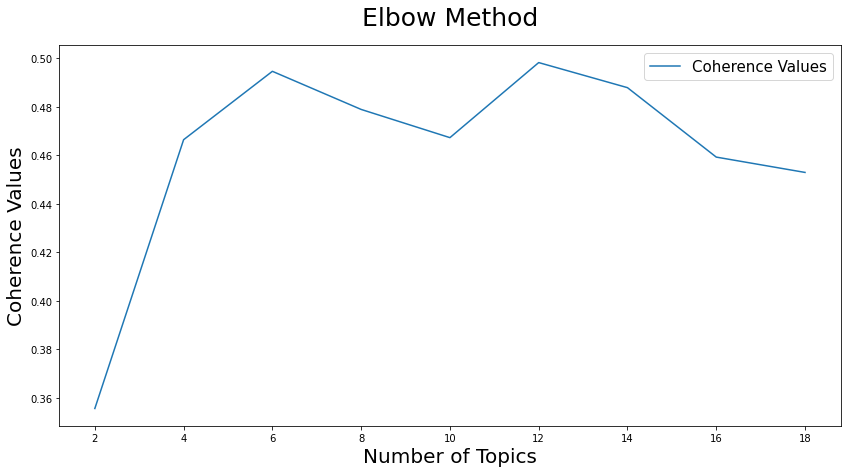

In [8]:
# plot results
plt.rcParams['figure.figsize'] = [14, 7]
x = range(start, limit, step)
plt.plot(x, coherence_scores, label = "Coherence Values")
plt.xlabel("Number of Topics", fontsize = 20)
plt.ylabel("Coherence Values", fontsize = 20)
plt.legend(loc = "upper right", fontsize = 15)
plt.title('Elbow Method', fontsize = 25, pad = 20)
plt.show()

In [9]:
# examine coherence values
for number_topics, cv in zip(x, coherence_scores):
    print(number_topics, 'topics have a coherence value of', round(cv, 3))

2 topics have a coherence value of 0.356
4 topics have a coherence value of 0.466
6 topics have a coherence value of 0.495
8 topics have a coherence value of 0.479
10 topics have a coherence value of 0.467
12 topics have a coherence value of 0.498
14 topics have a coherence value of 0.488
16 topics have a coherence value of 0.459
18 topics have a coherence value of 0.453


## Latent Dirichlet Allocation

In [10]:
# build topic model
number_topics = 6
topic_model_lda = lda_model(number_topics)

In [11]:
# compute perplexity
print('Perplexity: ', round(topic_model_lda.log_perplexity(corpus), 3))

# compute coherence value
coherence_topic_model_lda = coherence_values(topic_model_lda)
coherence_topic_model_lda_values = coherence_topic_model_lda.get_coherence()
print('Coherence Value: ', round(coherence_topic_model_lda_values, 3))

Perplexity:  -7.199
Coherence Value:  0.495


In [12]:
# create data frame of topics with corresponding keywords
lda_topics = [[(term, round(weight, 3)) for term, weight in topic_model_lda.show_topic(n, topn = 20)] 
              for n in range(0, topic_model_lda.num_topics)]
lda_topics_df = pd.DataFrame([', '.join([term for term, weight in topic]) 
                              for topic in lda_topics], columns = ['keywords'],
                             index = ['topic_' + str(t) for t in range(1, topic_model_lda.num_topics + 1)] )

In [13]:
# replace generic index with topic names
index_names = lda_topics_df.index.values.tolist()
topic_names = ['labour market', 'support system', 'politics', 'international role', 
               'defence', 'american dream']
lda_topics_df = lda_topics_df.rename(index = dict(zip(index_names, topic_names)))

In [14]:
# print data frame
pd.set_option('display.max_colwidth', 0)
lda_topics_df

,keywords
labour market,"economy, pay, business, company, plan, create, worker, cut, family, reform, future, let, government, bill, deficit, investment, education, percent, build, mean"
support system,"life, family, day, love, man, tell, child, story, great, home, hope, serve, heart, live, honor, faith, stand, veteran, community, service"
politics,"thing, question, sure, lot, issue, president_obama, try, look, happen, important, start, talk, able, president, problem, law, fact, point, election, folk"
international role,"continue, region, security, issue, international, strong, agreement, global, deal, support, include, united_state, economy, cooperation, commitment, progress, peace, question, sanction, nuclear"
defence,"isil, force, military, terrorist, attack, continue, troop, fight, war, government, syria, include, effort, support, threat, protect, intelligence, security, kill, life"
american dream,"democracy, young, believe, change, government, future, opportunity, live, history, build, great, progress, child, leader, woman, power, life, freedom, citizen, generation"


In [15]:
# reset display settings
pd.reset_option('^display.', silent = True)

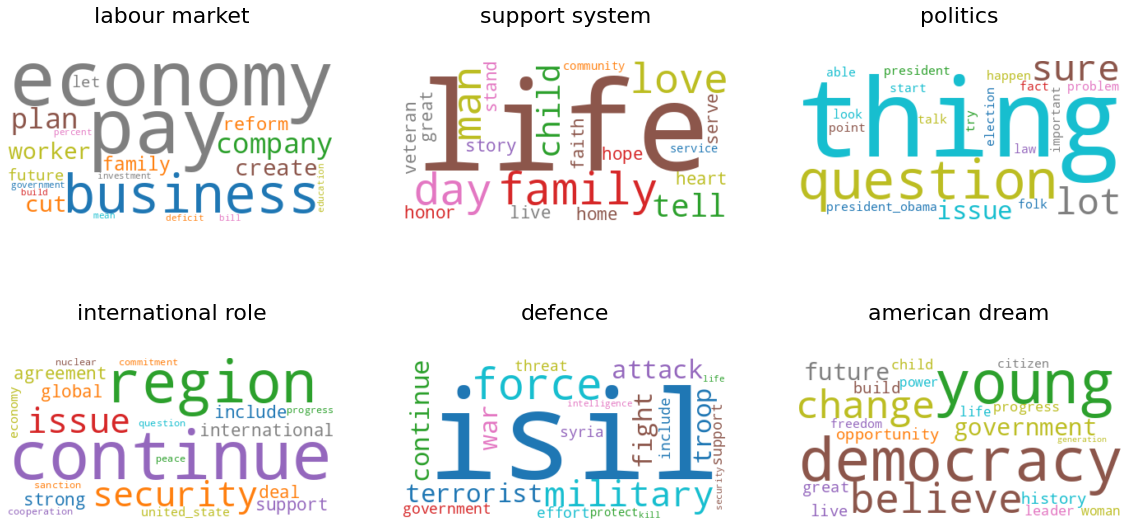

In [16]:
# plot settings
wc = WordCloud(background_color = "white", colormap = "tab10",
               max_font_size = 150, random_state = 42)
plt.rcParams['figure.figsize'] = [20, 10]

# create wordcloud for each topic
for i in range(topic_model_lda.num_topics):
    wc.generate(text = lda_topics_df["keywords"][i])
    plt.subplot(2, 3, i + 1)
    plt.imshow(wc, interpolation = "bilinear")
    plt.axis("off")
    plt.title(lda_topics_df.index[i], fontsize = 22, y = 1.2)

## Topic Distribution by Years

In [17]:
# get filenames
name = []
for i in range(len(speeches) ):
               index = "file_" + str(i + 1)
               name.append(index)
            
# extract distribution of topics by speech
topic_distribution_speeches = [topic_model_lda.get_document_topics(item, 
                                                                   minimum_probability = 0.0) for item in corpus]
            
# create data frame of topic distributions by speech
lda_df_proportions = pd.DataFrame.from_records([{v: k for v, k in row} for row in topic_distribution_speeches], 
                                               index = name)
lda_df_proportions.columns = topic_names

# import dates of speeches
speeches_df = pd.read_excel("output/obama_speeches.xlsx", index_col = 0, usecols = ["Unnamed: 0", 'date'])

# merge dates with topic distributions
df_merged = pd.merge(lda_df_proportions, speeches_df, left_index = True, right_index = True)

In [18]:
def yearly_distribution(data):
    # extract year of speeches
    data['year'] = data['date'].dt.year.convert_dtypes()

    # average topic distribution per year
    topic_distribution_df = data.groupby('year', as_index = False)[topic_names].mean().copy()

    # transform data frame from wide to long format
    topic_distribution_df_melt = topic_distribution_df.melt(id_vars = 'year', value_vars = topic_names, 
                                                        var_name = 'topic', value_name = 'prevelance')
    
    # plot topic distribution by year
    sns.set_style("whitegrid")
    plt.rcParams['figure.figsize'] = [14, 7]
    topics_by_year = sns.lineplot(data = topic_distribution_df_melt, x = "year", y = "prevelance", hue = "topic",
                              linewidth = 2.5)
    topics_by_year.set_xlabel("Year", fontsize = 20)
    topics_by_year.set_ylabel("Prevalence", fontsize = 20)
    plt.legend(ncol = 2, loc = 'upper center', fontsize = 13, title = "Topics", title_fontsize = 15, markerscale = 1.5)
    plt.title('Topic Distribution by Year', fontsize = 25, pad = 20)
    plt.show()

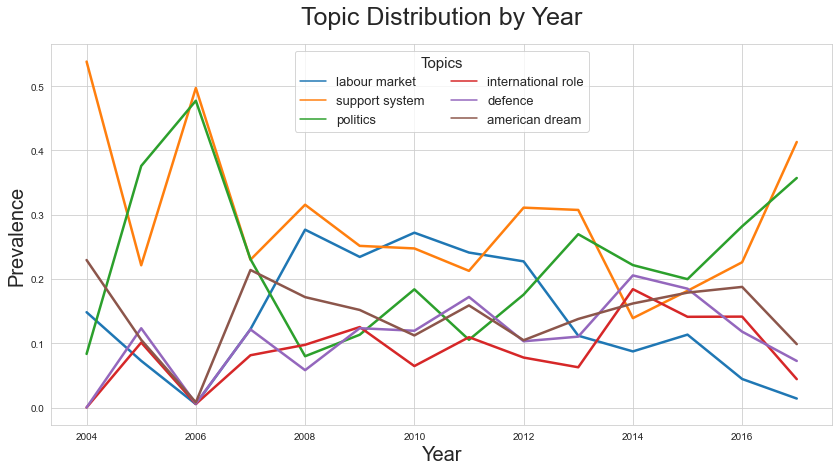

In [19]:
yearly_distribution(df_merged)

In [20]:
# write data frame to excel file
df_merged.to_excel("output/lda_output.xlsx")